In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from landlab import RasterModelGrid, imshow_grid
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter, SpaceLargeScaleEroder

# --- Read elevation grid from ESRI ASCII ---
rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED

In [ ]:
#Let's look at our watershed topography
rmg.imshow("topographic__elevation", vmin=1650)  # , vmin=1650.0)

In [ ]:


# --- Initialize soil depth before erosion component ---
s = rmg.add_zeros("soil__depth", at="node", dtype=float)
s += 0.3
z += s  # Add soil to elevation

# --- Set outlet node ---
my_outlet_node = 100
rmg.status_at_node[my_outlet_node] = rmg.BC_NODE_IS_FIXED_VALUE

# --- Flow routing and erosion components ---
fr = PriorityFloodFlowRouter(rmg, flow_metric="D8", update_flow_depressions=True)
ha = SpaceLargeScaleEroder(
    rmg, K_sed=0.0001, K_br=0.0001, phi=0.3, H_star=1.0
)

# --- Evolve landscape ---
space_dt = 100
br = rmg.at_node["bedrock__elevation"]
z = rmg.at_node["topographic__elevation"]

for _ in tqdm(range(250), desc="Evolving terrain"):
    # Uniform uplift
    br[rmg.core_nodes] += 0.001 * space_dt
    z[rmg.core_nodes] = br[rmg.core_nodes] + s[rmg.core_nodes]

    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

# --- Plot result ---
imshow_grid(rmg, "topographic__elevation", vmin=1650, cmap="terrain")
plt.title("Final topographic__elevation")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from landlab.io import read_esri_ascii
from landlab import imshow_grid

# Load the same grid used for the original simulation
rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")

# Folder where topography .npy files were saved
output_dir = "output_topography"

# Steps you want to plot (must match saved files)
saved_steps = [0, 5, 10, 50, 100, 250, 500, 1000]

for step in saved_steps:
    # Load topography array
    file_path = os.path.join(output_dir, f"topography_step_{step}.npy")
    if os.path.exists(file_path):
        z_loaded = np.load(file_path)

        # Update the grid's elevation field
        rmg.at_node["topographic__elevation"] = z_loaded

        # Plot and save
        imshow_grid(rmg, "topographic__elevation", cmap="terrain")
        plt.title(f"Topography at Step {step}")
        plt.savefig(os.path.join(output_dir, f"topography_plot_step_{step}.png"))
        plt.close()
    else:
        print(f"File not found: {file_path}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from landlab import RasterModelGrid, imshow_grid
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter, SpaceLargeScaleEroder

# --- Read elevation grid from ESRI ASCII ---
rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED

# --- Initialize soil depth before erosion component ---
s = rmg.add_zeros("soil__depth", at="node", dtype=float)
s += 0.3
z += s  # Add soil to elevation

# --- Save initial topography ---
initial_topo = z.copy()
plt.figure()
imshow_grid(rmg, initial_topo, vmin=1650, cmap="terrain")
plt.title("Initial Topography")
plt.savefig("initial_topography.png")
plt.show()

# --- Set outlet node ---
my_outlet_node = 100
rmg.status_at_node[my_outlet_node] = rmg.BC_NODE_IS_FIXED_VALUE

# --- Flow routing and erosion components ---
fr = PriorityFloodFlowRouter(rmg, flow_metric="D8", update_flow_depressions=True)
ha = SpaceLargeScaleEroder(
    rmg, K_sed=0.0001, K_br=0.0001, phi=0.3, H_star=1.0
)

# --- Evolve landscape ---
space_dt = 100
br = rmg.at_node["bedrock__elevation"]
z = rmg.at_node["topographic__elevation"]

for _ in tqdm(range(250), desc="Evolving terrain"):
    br[rmg.core_nodes] += 0.001 * space_dt
    z[rmg.core_nodes] = br[rmg.core_nodes] + s[rmg.core_nodes]
    fr.run_one_step()
    ha.run_one_step(dt=space_dt)

# --- Plot and save final topography ---
plt.figure()
imshow_grid(rmg, "topographic__elevation", vmin=1650, cmap="terrain")
plt.title("Final Topography After 250 Steps")
plt.savefig("final_topography.png")
plt.show()


# Introduction to the ErosionDeposition component

In [ ]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from landlab.components import PriorityFloodFlowRouter
from landlab.components import ErosionDeposition, FlowAccumulator
from landlab.plot import imshow_grid

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from landlab import HexModelGrid, RasterModelGrid
from landlab.components import (
    DepressionFinderAndRouter,
    FlowAccumulator,
    FlowDirectorD8,
    FlowDirectorSteepest,
)
from landlab.plot.drainage_plot import drainage_plot

In [ ]:
# Parameters
#nrows = 41
#ncols = 41
dx = 100.0
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion
initial_elevation = (
    200.0  # starting elevation of an "uplifted block" (rapid baselevel drop), m
)

run_duration = 1200.0  # duration of run, yr
dt = 10.0  # time-step duration, yr
plot_every = 200.0  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])

In [ ]:
#fa = PriorityFlodFlowRouter(rmg)

# this is the same as writing:
fa = PriorityFloodFlowRouter(
    rmg,
    surface="topographic__elevation",
    flow_metric="D8",
    update_flow_depressions=True,
    runoff_rate=None,
    depression_handler="breach",
)
fa.run_one_step()

plt.figure()
drainage_plot(rmg)

In [ ]:
#fr = FlowAccumulator(rmg, depression_finder="DepressionFinderAndRouter")
ed = ErosionDeposition(
    rmg,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",  # use the adaptive time stepper, which is slightly faster
)

In [ ]:
for i in range(1, nsteps + 1):
    # route flow
    fa.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    ed.run_one_step(dt)

    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            rmg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every

# Single step

In [8]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter
from landlab.components import ErosionDeposition, FlowAccumulator
from landlab.plot import imshow_grid

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from landlab import HexModelGrid, RasterModelGrid
from landlab.components import (
    DepressionFinderAndRouter,
    FlowAccumulator,
    FlowDirectorD8,
    FlowDirectorSteepest,
)
from landlab.plot.drainage_plot import drainage_plot



# --- Read elevation grid from ESRI ASCII ---
rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED

/tmp/ipykernel_750305/4110636512.py:27: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


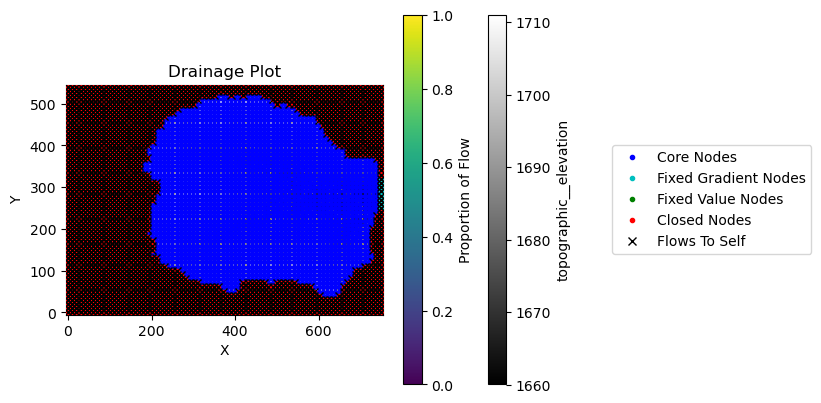

In [9]:
#fa = PriorityFlodFlowRouter(rmg)

# this is the same as writing:
fa = PriorityFloodFlowRouter(
    rmg,
    surface="topographic__elevation",
    flow_metric="D8",
    update_flow_depressions=True,
    runoff_rate=None,
    depression_handler="breach",
)
fa.run_one_step()

plt.figure()
drainage_plot(rmg)

In [13]:
K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion
initial_elevation = (
    200.0  # starting elevation of an "uplifted block" (rapid baselevel drop), m
)

run_duration = 1  # duration of run, yr
dt = 1  # time-step duration, yr
plot_every = 1  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])

In [14]:
ed = ErosionDeposition(
    rmg,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",  # use the adaptive time stepper, which is slightly faster
)

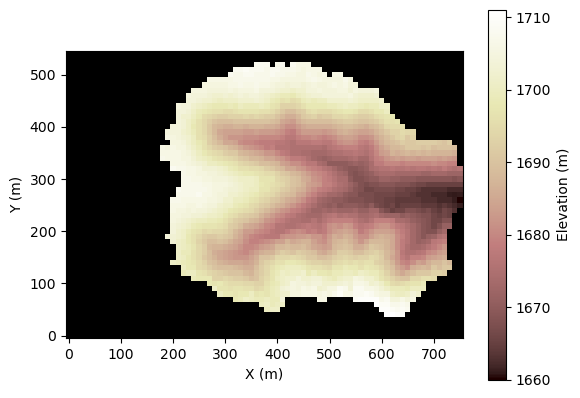

In [15]:
for i in range(1, nsteps + 1):
    # route flow
    fa.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    ed.run_one_step(dt)

    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            rmg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every

# Combining all singlestep code into one step

/tmp/ipykernel_750305/686116209.py:27: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


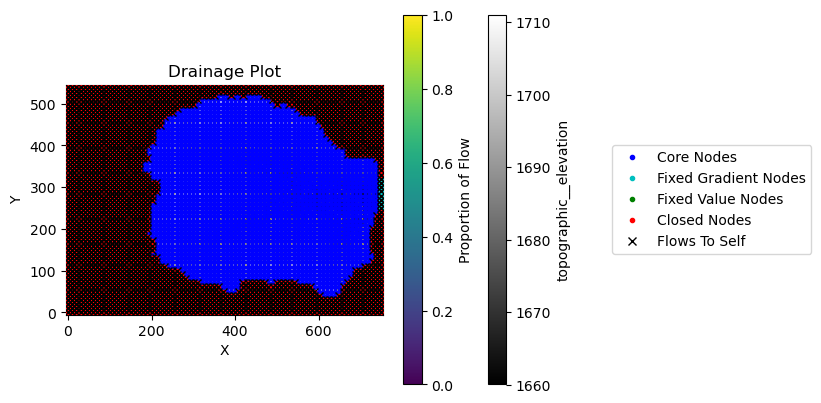

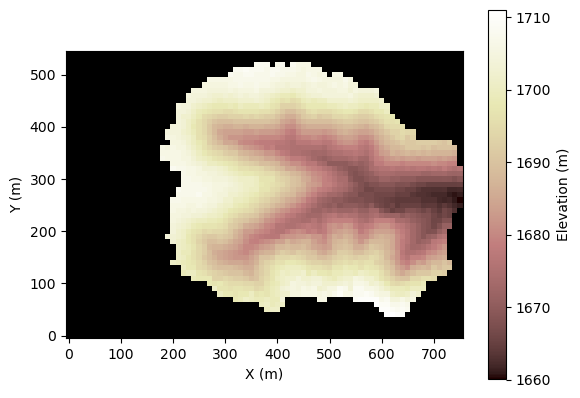

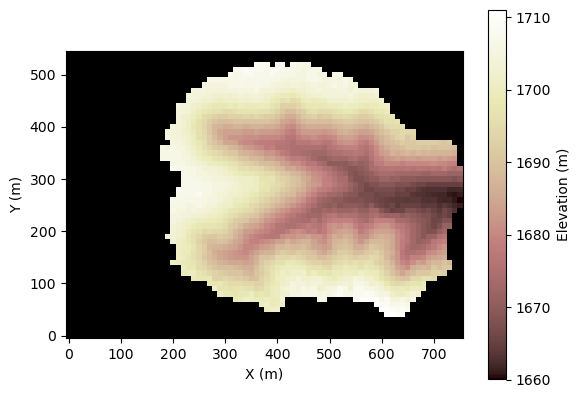

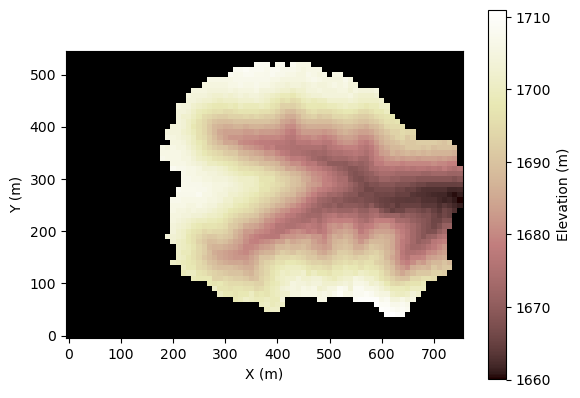

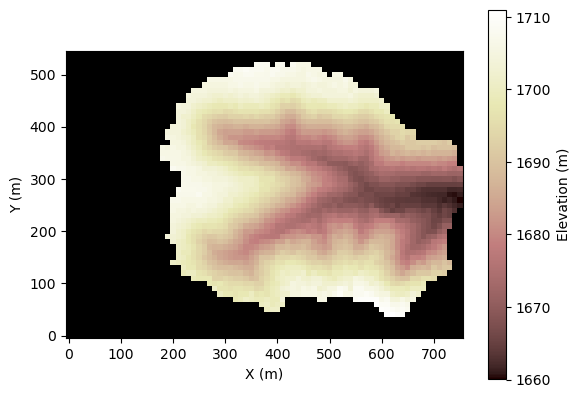

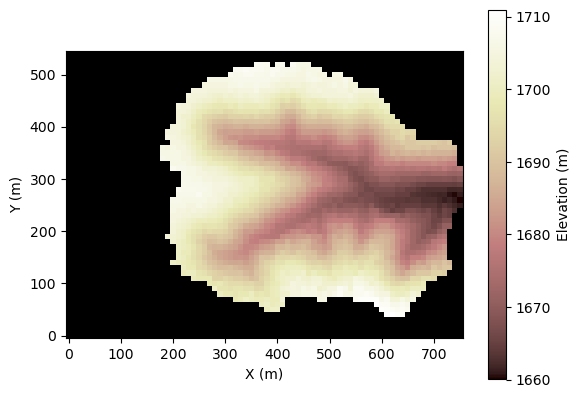

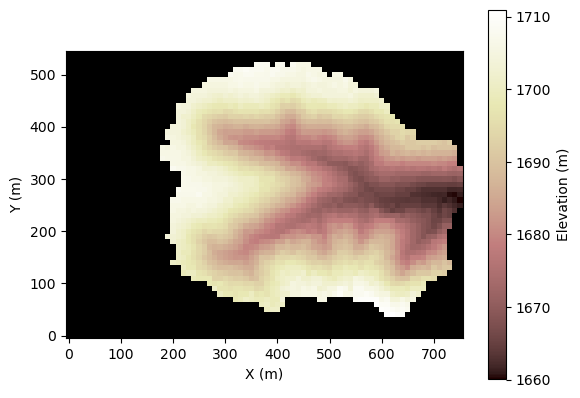

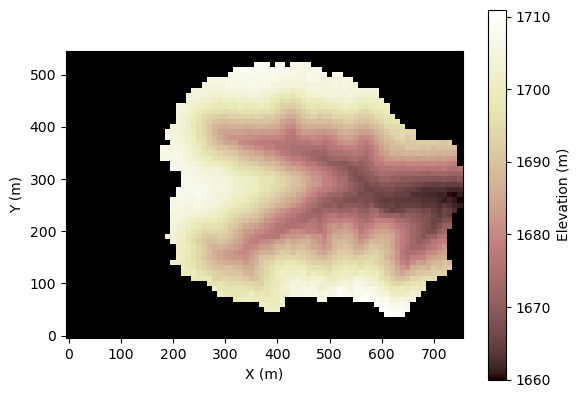

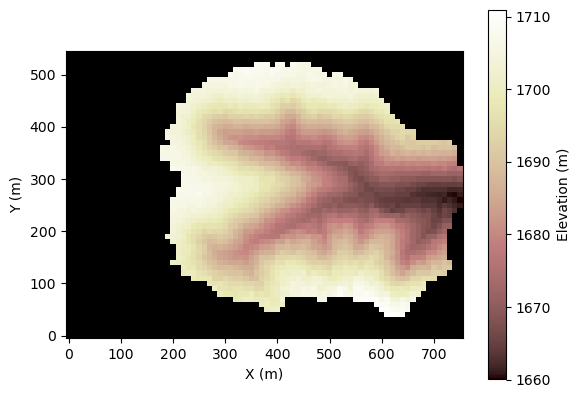

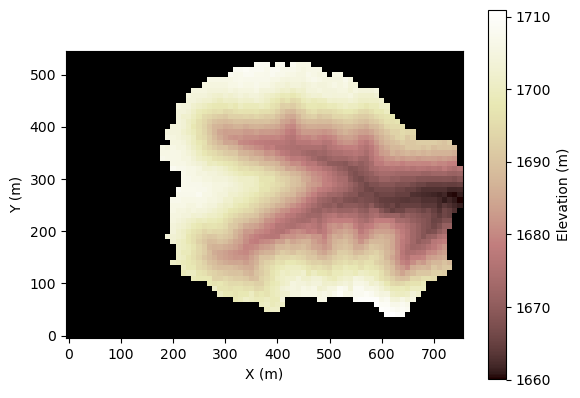

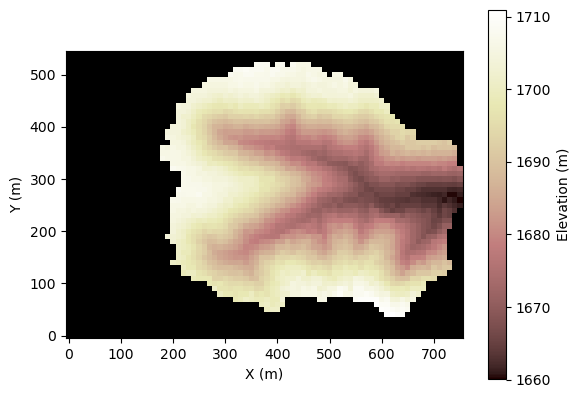

In [23]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from landlab.io import read_esri_ascii
from landlab.components import PriorityFloodFlowRouter
from landlab.components import ErosionDeposition, FlowAccumulator
from landlab.plot import imshow_grid

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from landlab import HexModelGrid, RasterModelGrid
from landlab.components import (
    DepressionFinderAndRouter,
    FlowAccumulator,
    FlowDirectorD8,
    FlowDirectorSteepest,
)
from landlab.plot.drainage_plot import drainage_plot



# --- Read elevation grid from ESRI ASCII ---
rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED


# this is the same as writing:
fa = PriorityFloodFlowRouter(
    rmg,
    surface="topographic__elevation",
    flow_metric="D8",
    update_flow_depressions=True,
    runoff_rate=None,
    depression_handler="breach",
)
fa.run_one_step()

plt.figure()
drainage_plot(rmg)

K = 0.0001  # erodibility coefficient, 1/yr
m_sp = 0.5  # exponent on drainage area or discharge, -
n_sp = 1.0  # exponent on slope, -
sp_crit = 0.0  # erosion threshold
v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
F_f = 0.5  # fraction of fines generated during bed erosion
initial_elevation = (
    200.0  # starting elevation of an "uplifted block" (rapid baselevel drop), m
)

run_duration = 1000  # duration of run, yr
dt = 10  # time-step duration, yr
plot_every = 100  # time interval for plotting, yr

# Derived parameters
nsteps = int(run_duration / dt)
next_plot = plot_every

# set up colormap
cmap = copy.copy(mpl.colormaps["pink"])

ed = ErosionDeposition(
    rmg,
    K=K,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit=sp_crit,
    v_s=v_s,
    F_f=F_f,
    solver="adaptive",  # use the adaptive time stepper, which is slightly faster
)

for i in range(1, nsteps + 1):
    # route flow
    fa.run_one_step()  # run_one_step isn't time sensitive, so it doesn't take dt as input

    # do some erosion/deposition
    ed.run_one_step(dt)

    if i * dt >= next_plot:
        plt.figure()
        imshow_grid(
            rmg,
            "topographic__elevation",
            grid_units=["m", "m"],
            var_name="Elevation (m)",
            cmap=cmap,
        )
        next_plot += plot_every


/tmp/ipykernel_750305/171060311.py:89: DeprecationWarning: landlab.io.read_esri_ascii has been deprecated, use landlab.io.esri_ascii.load instead
  rmg, z = setup_model_grid()
/tmp/ipykernel_750305/171060311.py:20: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


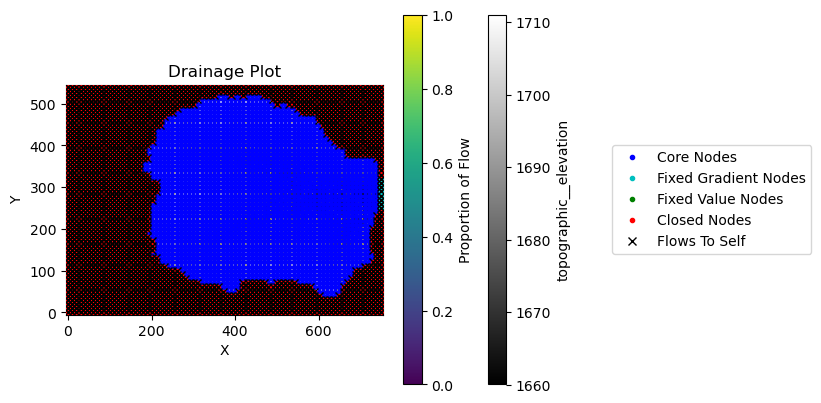

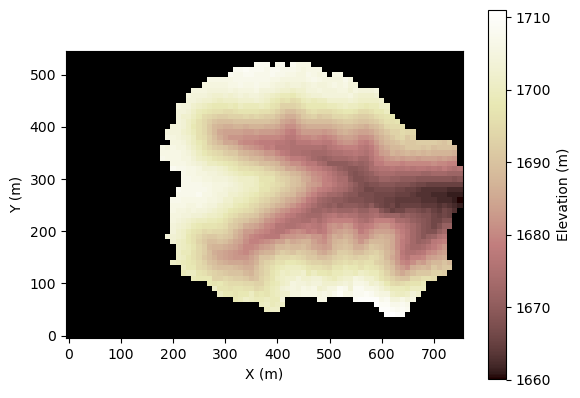

In [17]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from landlab import HexModelGrid, RasterModelGrid
from landlab.io import read_esri_ascii
from landlab.components import (
    PriorityFloodFlowRouter,
    ErosionDeposition,
    FlowAccumulator,
    FlowDirectorD8,
    FlowDirectorSteepest,
    DepressionFinderAndRouter,
)
from landlab.plot import imshow_grid
from landlab.plot.drainage_plot import drainage_plot

def setup_model_grid():
    """Read the elevation grid and initialize the model grid."""
    rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
    rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED
    return rmg, z

def initialize_flow_accumulator(rmg):
    """Initialize the flow accumulator with appropriate parameters."""
    fa = PriorityFloodFlowRouter(
        rmg,
        surface="topographic__elevation",
        flow_metric="D8",
        update_flow_depressions=True,
        runoff_rate=None,
        depression_handler="breach",
    )
    return fa

def initialize_erosion_deposition(rmg):
    """Initialize the Erosion/Deposition component with model parameters."""
    K = 0.0001  # erodibility coefficient, 1/yr
    m_sp = 0.5  # exponent on drainage area or discharge, -
    n_sp = 1.0  # exponent on slope, -
    sp_crit = 0.0  # erosion threshold
    v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
    F_f = 0.5  # fraction of fines generated during bed erosion

    ed = ErosionDeposition(
        rmg,
        K=K,
        m_sp=m_sp,
        n_sp=n_sp,
        sp_crit=sp_crit,
        v_s=v_s,
        F_f=F_f,
        solver="adaptive",  # use the adaptive time stepper, which is slightly faster
    )
    return ed

def run_simulation(rmg, fa, ed, run_duration=1, dt=1, plot_every=1):
    """Run the simulation for a specified duration and plot results periodically."""
    # Derived parameters
    nsteps = int(run_duration / dt)
    next_plot = plot_every

    # Set up colormap
    cmap = copy.copy(mpl.colormaps["pink"])

    # Run the simulation
    for i in range(1, nsteps + 1):
        # Route flow
        fa.run_one_step()

        # Perform erosion/deposition
        ed.run_one_step(dt)

        # Plot periodically
        if i * dt >= next_plot:
            plt.figure()
            imshow_grid(
                rmg,
                "topographic__elevation",
                grid_units=["m", "m"],
                var_name="Elevation (m)",
                cmap=cmap,
            )
            next_plot += plot_every

def main():
    """Main function to run the model and generate plots."""
    # Set up model grid and components
    rmg, z = setup_model_grid()
    fa = initialize_flow_accumulator(rmg)
    ed = initialize_erosion_deposition(rmg)

    # Run the initial flow routing step
    fa.run_one_step()

    # Plot drainage pattern
    plt.figure()
    drainage_plot(rmg)

    # Run the simulation
    run_simulation(rmg, fa, ed)

if __name__ == "__main__":
    main()


/tmp/ipykernel_750305/4220576367.py:105: DeprecationWarning: landlab.io.read_esri_ascii has been deprecated, use landlab.io.esri_ascii.load instead
  rmg, z = setup_model_grid()
/tmp/ipykernel_750305/4220576367.py:21: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


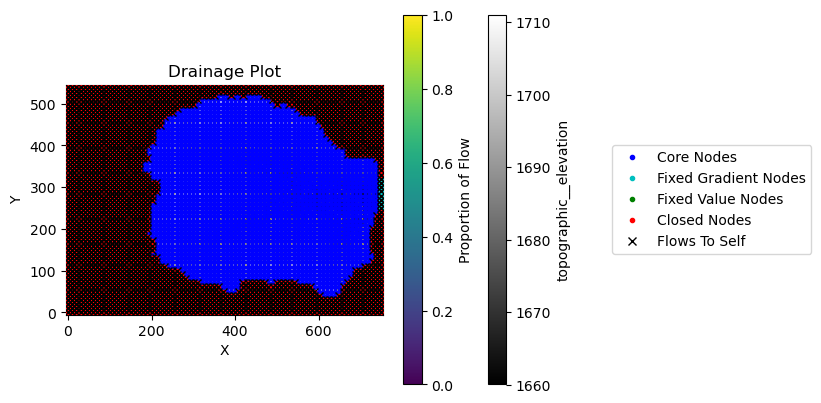

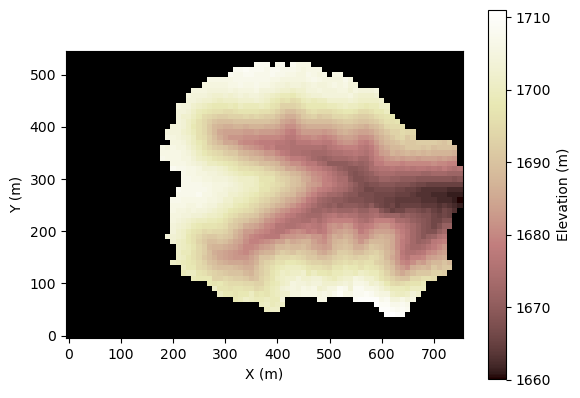

In [18]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import csv
from landlab import HexModelGrid, RasterModelGrid
from landlab.io import read_esri_ascii
from landlab.components import (
    PriorityFloodFlowRouter,
    ErosionDeposition,
    FlowAccumulator,
    FlowDirectorD8,
    FlowDirectorSteepest,
    DepressionFinderAndRouter,
)
from landlab.plot import imshow_grid
from landlab.plot.drainage_plot import drainage_plot

def setup_model_grid():
    """Read the elevation grid and initialize the model grid."""
    rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
    rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED
    return rmg, z

def initialize_flow_accumulator(rmg):
    """Initialize the flow accumulator with appropriate parameters."""
    fa = PriorityFloodFlowRouter(
        rmg,
        surface="topographic__elevation",
        flow_metric="D8",
        update_flow_depressions=True,
        runoff_rate=None,
        depression_handler="breach",
    )
    return fa

def initialize_erosion_deposition(rmg):
    """Initialize the Erosion/Deposition component with model parameters."""
    K = 0.0001  # erodibility coefficient, 1/yr
    m_sp = 0.5  # exponent on drainage area or discharge, -
    n_sp = 1.0  # exponent on slope, -
    sp_crit = 0.0  # erosion threshold
    v_s = 100.0  # settling velocity parameter (dimensionless if drainage area is used instead of discharge)
    F_f = 0.5  # fraction of fines generated during bed erosion

    ed = ErosionDeposition(
        rmg,
        K=K,
        m_sp=m_sp,
        n_sp=n_sp,
        sp_crit=sp_crit,
        v_s=v_s,
        F_f=F_f,
        solver="adaptive",  # use the adaptive time stepper, which is slightly faster
    )
    return ed

def store_grid_data(rmg, z, filename="grid_data.csv"):
    """Store grid values (x, y) and elevation (z) in a CSV file."""
    # Extracting x, y coordinates from the grid and elevation values
    x, y = rmg.node_x, rmg.node_y
    elevation = z
    
    # Prepare data for CSV
    data = zip(x, y, elevation)
    
    # Write to CSV file
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['x', 'y', 'elevation'])  # Write header
        writer.writerows(data)  # Write data rows

def run_simulation(rmg, fa, ed, run_duration=1, dt=1, plot_every=1):
    """Run the simulation for a specified duration and plot results periodically."""
    # Derived parameters
    nsteps = int(run_duration / dt)
    next_plot = plot_every

    # Set up colormap
    cmap = copy.copy(mpl.colormaps["pink"])

    # Run the simulation
    for i in range(1, nsteps + 1):
        # Route flow
        fa.run_one_step()

        # Perform erosion/deposition
        ed.run_one_step(dt)

        # Plot periodically
        if i * dt >= next_plot:
            plt.figure()
            imshow_grid(
                rmg,
                "topographic__elevation",
                grid_units=["m", "m"],
                var_name="Elevation (m)",
                cmap=cmap,
            )
            next_plot += plot_every

def main():
    """Main function to run the model, generate plots, and store grid data in CSV."""
    # Set up model grid and components
    rmg, z = setup_model_grid()
    fa = initialize_flow_accumulator(rmg)
    ed = initialize_erosion_deposition(rmg)

    # Run the initial flow routing step
    fa.run_one_step()

    # Plot drainage pattern
    plt.figure()
    drainage_plot(rmg)

    # Store the initial grid data (before simulation)
    store_grid_data(rmg, z, filename="initial_grid_data.csv")

    # Run the simulation
    run_simulation(rmg, fa, ed)

    # Store the final grid data (after simulation)
    store_grid_data(rmg, rmg.at_node['topographic__elevation'], filename="final_grid_data.csv")

if __name__ == "__main__":
    main()


/tmp/ipykernel_750305/2477751416.py:88: DeprecationWarning: landlab.io.read_esri_ascii has been deprecated, use landlab.io.esri_ascii.load instead
  rmg = setup_model_grid()
/tmp/ipykernel_750305/2477751416.py:22: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


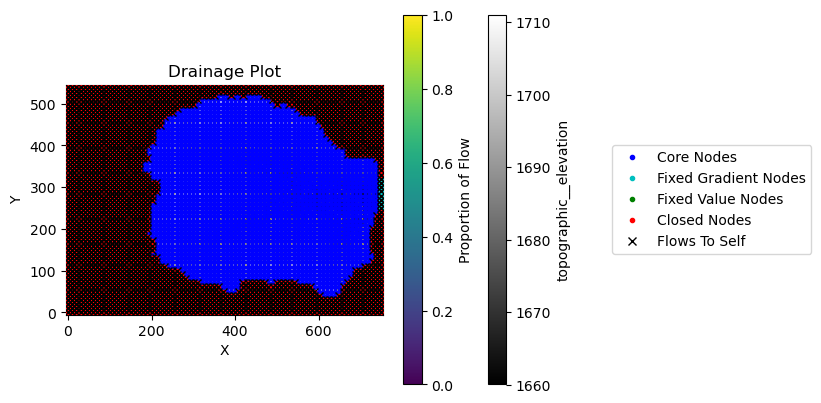

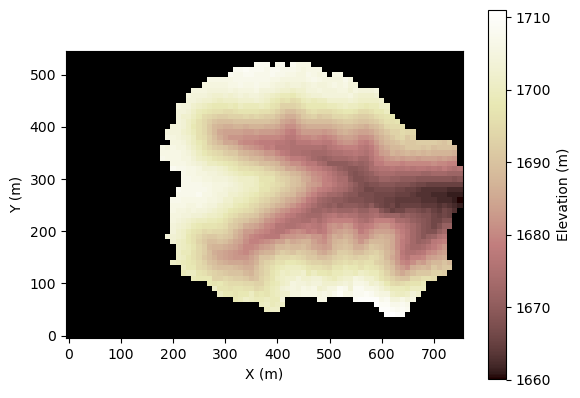

In [19]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import csv
from landlab import RasterModelGrid
from landlab.io import read_esri_ascii
from landlab.components import (
    PriorityFloodFlowRouter,
    ErosionDeposition,
    FlowAccumulator,
    FlowDirectorD8,
    FlowDirectorSteepest,
    DepressionFinderAndRouter,
)
from landlab.plot import imshow_grid
from landlab.plot.drainage_plot import drainage_plot


def setup_model_grid():
    """Read the elevation grid and initialize the model grid."""
    rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
    rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED
    return rmg


def initialize_flow_accumulator(rmg):
    """Initialize the flow accumulator with appropriate parameters."""
    return PriorityFloodFlowRouter(
        rmg,
        surface="topographic__elevation",
        flow_metric="D8",
        update_flow_depressions=True,
        runoff_rate=None,
        depression_handler="breach",
    )


def initialize_erosion_deposition(rmg):
    """Initialize the Erosion/Deposition component with model parameters."""
    return ErosionDeposition(
        rmg,
        K=0.0001,     # erodibility coefficient, 1/yr
        m_sp=0.5,     # exponent on drainage area or discharge
        n_sp=1.0,     # exponent on slope
        sp_crit=0.0,  # erosion threshold
        v_s=100.0,    # settling velocity parameter
        F_f=0.5,      # fraction of fines generated during bed erosion
        solver="adaptive"
    )


def run_simulation(rmg, fa, ed, run_duration=1, dt=1, plot_every=1):
    """Run the simulation for a specified duration and plot results periodically."""
    nsteps = int(run_duration / dt)
    next_plot = plot_every
    cmap = copy.copy(mpl.colormaps["pink"])

    for i in range(1, nsteps + 1):
        fa.run_one_step()
        ed.run_one_step(dt)

        if i * dt >= next_plot:
            plt.figure()
            imshow_grid(
                rmg,
                "topographic__elevation",
                grid_units=["m", "m"],
                var_name="Elevation (m)",
                cmap=cmap,
            )
            next_plot += plot_every


def store_grid_data(rmg, initial_elevation, final_elevation, filename="grid_comparison.csv"):
    """Store x, y, initial elevation, and final elevation in a CSV file."""
    x, y = rmg.node_x, rmg.node_y
    data = zip(x, y, initial_elevation, final_elevation)

    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['x', 'y', 'initial_elevation', 'final_elevation'])
        writer.writerows(data)


def main():
    """Main function to run the model and store grid data."""
    rmg = setup_model_grid()
    fa = initialize_flow_accumulator(rmg)
    ed = initialize_erosion_deposition(rmg)

    # Store initial elevation before any simulation
    initial_elevation = rmg.at_node["topographic__elevation"].copy()

    # Initial flow routing and plot
    fa.run_one_step()
    plt.figure()
    drainage_plot(rmg)

    # Run simulation
    run_simulation(rmg, fa, ed)

    # Final elevation after simulation
    final_elevation = rmg.at_node["topographic__elevation"]

    # Save initial and final data to one CSV
    store_grid_data(rmg, initial_elevation, final_elevation)


if __name__ == "__main__":
    main()


In [20]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import csv
from landlab.io import read_esri_ascii
from landlab import RasterModelGrid
from landlab.components import (
    PriorityFloodFlowRouter,
    ErosionDeposition,
)
from landlab.plot import imshow_grid
from landlab.plot.drainage_plot import drainage_plot


def setup_model_grid():
    """Read the elevation grid and initialize the model grid."""
    rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
    rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED
    return rmg


def initialize_flow_accumulator(rmg):
    """Initialize the flow accumulator with appropriate parameters."""
    return PriorityFloodFlowRouter(
        rmg,
        surface="topographic__elevation",
        flow_metric="D8",
        update_flow_depressions=True,
        runoff_rate=None,
        depression_handler="breach",
    )


def initialize_erosion_deposition(rmg, m_sp):
    """Initialize Erosion/Deposition with a specific m_sp value."""
    return ErosionDeposition(
        rmg,
        K=0.0001,
        m_sp=m_sp,
        n_sp=1.0,
        sp_crit=0.0,
        v_s=100.0,
        F_f=0.5,
        solver="adaptive"
    )


def run_simulation(rmg, fa, ed, run_duration=1, dt=1):
    """Run a short simulation."""
    nsteps = int(run_duration / dt)
    for _ in range(nsteps):
        fa.run_one_step()
        ed.run_one_step(dt)


def run_multiple_simulations(msp_values, run_duration=1, dt=1, output_file="grid_comparison_multi_msp.csv"):
    """Run simulations across different m_sp values and save final elevations."""
    rmg = setup_model_grid()
    fa = initialize_flow_accumulator(rmg)

    # Store coordinates and initial elevation
    x = rmg.node_x
    y = rmg.node_y
    initial_elevation = rmg.at_node["topographic__elevation"].copy()

    # Prepare results dictionary
    results = {
        "x": x,
        "y": y,
        "initial_elevation": initial_elevation,
    }

    for m_sp in msp_values:
        # Reset the grid for each run
        rmg = setup_model_grid()
        rmg.at_node["topographic__elevation"][:] = initial_elevation.copy()
        fa = initialize_flow_accumulator(rmg)
        ed = initialize_erosion_deposition(rmg, m_sp)

        # Run simulation
        run_simulation(rmg, fa, ed, run_duration, dt)

        # Store final elevation
        results[f"final_msp_{m_sp:.1f}"] = rmg.at_node["topographic__elevation"].copy()

    # Write results to CSV
    keys = list(results.keys())
    rows = zip(*(results[key] for key in keys))

    with open(output_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(keys)  # Header
        writer.writerows(rows)


def main():
    msp_values = np.round(np.arange(0.0, 1.11, 0.2), 2)  # 0.0 to 1.1 in 0.2 steps
    run_multiple_simulations(msp_values)


if __name__ == "__main__":
    main()


/tmp/ipykernel_750305/2761376255.py:59: DeprecationWarning: landlab.io.read_esri_ascii has been deprecated, use landlab.io.esri_ascii.load instead
  rmg = setup_model_grid()
/tmp/ipykernel_750305/2761376255.py:18: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
/tmp/ipykernel_750305/2761376255.py:76: DeprecationWarning: landlab.io.read_esri_ascii has been deprecated, use landlab.io.esri_ascii.load instead
  rmg = setup_model_grid()


In [21]:
import copy
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from landlab.io import read_esri_ascii
from landlab import RasterModelGrid
from landlab.components import PriorityFloodFlowRouter, ErosionDeposition
from landlab.plot import imshow_grid
from landlab.plot.drainage_plot import drainage_plot


def setup_model_grid():
    """Read elevation grid and set closed boundaries for negative elevation."""
    rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
    rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED
    return rmg


def initialize_flow_accumulator(rmg):
    return PriorityFloodFlowRouter(
        rmg,
        surface="topographic__elevation",
        flow_metric="D8",
        update_flow_depressions=True,
        runoff_rate=None,
        depression_handler="breach",
    )


def initialize_erosion_deposition(rmg, m_sp):
    return ErosionDeposition(
        rmg,
        K=0.0001,
        m_sp=m_sp,
        n_sp=1.0,
        sp_crit=0.0,
        v_s=100.0,
        F_f=0.5,
        solver="adaptive",
    )


def run_simulation(rmg, fa, ed, run_duration=1, dt=1):
    nsteps = int(run_duration / dt)
    for _ in range(nsteps):
        fa.run_one_step()
        ed.run_one_step(dt)


def get_open_node_id(rmg):
    """Find the ID of the single open node."""
    open_nodes = np.where(rmg.status_at_node == rmg.BC_NODE_IS_CORE)[0]
    if len(open_nodes) != 1:
        raise ValueError(f"Expected 1 open node, found {len(open_nodes)}.")
    return open_nodes[0]


def run_multiple_simulations(msp_values, run_duration=1, dt=1,
                             full_grid_file="grid_comparison_multi_msp.csv",
                             open_node_file="open_node_elevation.csv"):
    """Run simulations for each m_sp value and save full grid + open node elevation data."""

    # Initialize base grid
    rmg = setup_model_grid()
    fa = initialize_flow_accumulator(rmg)
    initial_elevation = rmg.at_node["topographic__elevation"].copy()
    x = rmg.node_x
    y = rmg.node_y

    # Identify the open node
    open_node_id = get_open_node_id(rmg)

    # Prepare result dictionaries
    full_grid_results = {
        "x": x,
        "y": y,
        "initial_elevation": initial_elevation,
    }
    open_node_results = {
        "node_id": open_node_id,
        "initial_elevation": initial_elevation[open_node_id],
    }

    # Loop over m_sp values
    for m_sp in msp_values:
        # Reset grid
        rmg = setup_model_grid()
        rmg.at_node["topographic__elevation"][:] = initial_elevation.copy()
        fa = initialize_flow_accumulator(rmg)
        ed = initialize_erosion_deposition(rmg, m_sp)

        # Run erosion simulation
        run_simulation(rmg, fa, ed, run_duration, dt)

        # Store entire grid elevation
        full_grid_results[f"final_msp_{m_sp:.1f}"] = rmg.at_node["topographic__elevation"].copy()

        # Store open node elevation
        open_node_results[f"final_msp_{m_sp:.1f}"] = rmg.at_node["topographic__elevation"][open_node_id]

    # Write full grid data to CSV
    with open(full_grid_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(full_grid_results.keys())
        writer.writerows(zip(*full_grid_results.values()))

    # Write open node data to CSV
    with open(open_node_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(open_node_results.keys())
        writer.writerow(open_node_results.values())


def main():
    msp_values = np.round(np.arange(0.0, 1.11, 0.2), 2)  # m_sp = 0.0 to 1.1 in steps of 0.2
    run_multiple_simulations(msp_values)


if __name__ == "__main__":
    main()


/tmp/ipykernel_750305/4015991639.py:65: DeprecationWarning: landlab.io.read_esri_ascii has been deprecated, use landlab.io.esri_ascii.load instead
  rmg = setup_model_grid()
/tmp/ipykernel_750305/4015991639.py:15: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")


ValueError: Expected 1 open node, found 2144.

In [22]:
import copy
import csv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from landlab.io import read_esri_ascii
from landlab import RasterModelGrid
from landlab.components import PriorityFloodFlowRouter, ErosionDeposition
from landlab.plot import imshow_grid
from landlab.plot.drainage_plot import drainage_plot


def setup_model_grid():
    """Read elevation grid and set closed boundaries for negative elevation."""
    rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
    rmg.status_at_node[z < 0.0] = rmg.BC_NODE_IS_CLOSED
    return rmg


def initialize_flow_accumulator(rmg):
    return PriorityFloodFlowRouter(
        rmg,
        surface="topographic__elevation",
        flow_metric="D8",
        update_flow_depressions=True,
        runoff_rate=None,
        depression_handler="breach",
    )


def initialize_erosion_deposition(rmg, m_sp):
    return ErosionDeposition(
        rmg,
        K=0.0001,
        m_sp=m_sp,
        n_sp=1.0,
        sp_crit=0.0,
        v_s=100.0,
        F_f=0.5,
        solver="adaptive",
    )


def run_simulation(rmg, fa, ed, run_duration=1, dt=1):
    nsteps = int(run_duration / dt)
    for _ in range(nsteps):
        fa.run_one_step()
        ed.run_one_step(dt)


def get_lowest_node_id(rmg):
    """Return the ID of the lowest elevation node (ignoring closed)."""
    elev = rmg.at_node["topographic__elevation"]
    not_closed = rmg.status_at_node != rmg.BC_NODE_IS_CLOSED
    valid_nodes = np.where(not_closed)[0]
    min_node_id = valid_nodes[np.argmin(elev[valid_nodes])]
    return min_node_id


def run_multiple_simulations(msp_values, run_duration=1, dt=1,
                             full_grid_file="grid_comparison_multi_msp.csv",
                             low_node_file="lowest_node_elevation.csv"):
    """Run simulations for each m_sp value and save full grid + lowest node elevation data."""

    # Initialize base grid
    rmg = setup_model_grid()
    fa = initialize_flow_accumulator(rmg)
    initial_elevation = rmg.at_node["topographic__elevation"].copy()
    x = rmg.node_x
    y = rmg.node_y

    # Identify the lowest node
    tracking_node_id = get_lowest_node_id(rmg)

    # Prepare result dictionaries
    full_grid_results = {
        "x": x,
        "y": y,
        "initial_elevation": initial_elevation,
    }
    low_node_results = {
        "node_id": tracking_node_id,
        "initial_elevation": initial_elevation[tracking_node_id],
    }

    # Loop over m_sp values
    for m_sp in msp_values:
        # Reset grid
        rmg = setup_model_grid()
        rmg.at_node["topographic__elevation"][:] = initial_elevation.copy()
        fa = initialize_flow_accumulator(rmg)
        ed = initialize_erosion_deposition(rmg, m_sp)

        # Run erosion simulation
        run_simulation(rmg, fa, ed, run_duration, dt)

        # Store entire grid elevation
        full_grid_results[f"final_msp_{m_sp:.1f}"] = rmg.at_node["topographic__elevation"].copy()

        # Store lowest node elevation
        low_node_results[f"final_msp_{m_sp:.1f}"] = rmg.at_node["topographic__elevation"][tracking_node_id]

    # Write full grid data to CSV
    with open(full_grid_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(full_grid_results.keys())
        writer.writerows(zip(*full_grid_results.values()))

    # Write tracked node elevation to CSV
    with open(low_node_file, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(low_node_results.keys())
        writer.writerow(low_node_results.values())


def main():
    msp_values = np.round(np.arange(0.0, 1.11, 0.2), 2)  # m_sp = 0.0 to 1.1
    run_multiple_simulations(msp_values)


if __name__ == "__main__":
    main()


/tmp/ipykernel_750305/37375876.py:66: DeprecationWarning: landlab.io.read_esri_ascii has been deprecated, use landlab.io.esri_ascii.load instead
  rmg = setup_model_grid()
/tmp/ipykernel_750305/37375876.py:15: DeprecationWarning: landlab.io.read_asc_header has been deprecated, use landlab.io.esri_ascii.parse instead
  rmg, z = read_esri_ascii("hugo_site.asc", name="topographic__elevation")
/tmp/ipykernel_750305/37375876.py:89: DeprecationWarning: landlab.io.read_esri_ascii has been deprecated, use landlab.io.esri_ascii.load instead
  rmg = setup_model_grid()
